In [1]:
name = '2016-01-15-iris-trajectory'
title = 'Making a cross-section in iris'
tags = 'iris, matplotlib, cartopy'
author = 'Denis Sergeev'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML

html = connect_notebook_to_post(name, title, tags, author)

In the first meeting of 2016 we had a brief look at the [iris](http://scitools.org.uk/iris/docs/latest/index.html) package API and one of its many capabilities. The data is in the same [ERA-Interim](http://www.ecmwf.int/en/research/climate-reanalysis/era-interim) reanalysis [`data.nc`](https://github.com/ueapy/ueapy.github.io/blob/src/content/data/data.nc) file, which was used in our previous [exercises](http://ueapy.github.io/20-november-cartopy-example.html).

The idea is taken from [python4oceanographers blog](https://ocefpaf.github.io/python4oceanographers/blog/2015/04/06/bathymetry/).

OK, Python, load the modules!

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import iris
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
%matplotlib inline

Don't bother me with warnings!

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Read the NetCDF data file

The following switch is to automatically promote the reference surface variable associated with a dimensionless vertical coordinate. More info here: [PR1159](https://github.com/SciTools/iris/pull/1159).

In [6]:
iris.FUTURE.netcdf_promote = True

Use the simplest loading method to open a NetCDF file as a `iris.cube.Cubelist` variable `f`.

In [7]:
filepath = os.path.join(os.path.pardir,'data','data.nc') # ../data/data.nc on Unix
f = iris.load(filepath)
print(f)

0: atmosphere_relative_vorticity / (s**-1) (time: 2; pressure_level: 4; latitude: 241; longitude: 480)
1: divergence_of_wind / (s**-1)        (time: 2; pressure_level: 4; latitude: 241; longitude: 480)
2: eastward_wind / (m s**-1)           (time: 2; pressure_level: 4; latitude: 241; longitude: 480)
3: lagrangian_tendency_of_air_pressure / (Pa s**-1) (time: 2; pressure_level: 4; latitude: 241; longitude: 480)
4: northward_wind / (m s**-1)          (time: 2; pressure_level: 4; latitude: 241; longitude: 480)


Let's take the horizontal wind components from this list:

In [8]:
u, v = f[2], f[4]

In [9]:
print(u)
print('\nType of u variable: {}'.format(type(u)))

eastward_wind / (m s**-1)           (time: 2; pressure_level: 4; latitude: 241; longitude: 480)
     Dimension coordinates:
          time                           x                  -            -               -
          pressure_level                 -                  x            -               -
          latitude                       -                  -            x               -
          longitude                      -                  -            -               x
     Attributes:
          Conventions: CF-1.0
          history: 2015-04-26 19:20:07 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls03-a562cefde8a29a7288fa0b8b7f9413f7-Msj0Ul.target...

Type of u variable: <class 'iris.cube.Cube'>


Next, we construct a wind speed variable:

In [10]:
wspd = (u**2 + v**2)**0.5
wspd.rename('wind_magnitude')
print(wspd)

wind_magnitude / (meter-second^-1)  (time: 2; pressure_level: 4; latitude: 241; longitude: 480)
     Dimension coordinates:
          time                           x                  -            -               -
          pressure_level                 -                  x            -               -
          latitude                       -                  -            x               -
          longitude                      -                  -            -               x


Note that we are performing arithmetic operations on an `iris.cube.Cube`, and the units of the derived variable are also correct. Another random example of the `iris` handling units conversions:

In [11]:
(123*u*u.coord('time')/u.coord('pressure_level')).units

Unit('36 meter^2-kilogram^-1-second^2')

## Subset the cube

`iris` makes it also easier to subset a cube in a human-readable way, without worrying about indices and instead using the physical limits. We will cut an area between 120 and 160 degrees longitude and 30 and 60 degrees latitude (Japan and surrounding area). It is done using `iris.Constraint` class and then `extract()` attribute of the original cube.

In [12]:
sublon = iris.Constraint(longitude=lambda cell: 120 <= cell <= 160)
sublat = iris.Constraint(latitude=lambda cell: 30 <= cell <= 60)

wspd_subset = wspd.extract(sublon & sublat)

print(wspd_subset)

wind_magnitude / (meter-second^-1)  (time: 2; pressure_level: 4; latitude: 41; longitude: 54)
     Dimension coordinates:
          time                           x                  -            -              -
          pressure_level                 -                  x            -              -
          latitude                       -                  -            x              -
          longitude                      -                  -            -              x


In [13]:
import shapely.geometry as sgeom

Subset location


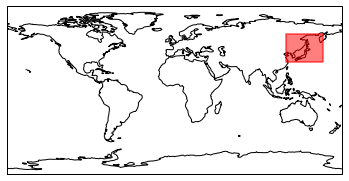

In [14]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
extent_box = sgeom.box(120,30,160,60)
ax.add_geometries([extent_box], ccrs.PlateCarree(), color='red', alpha=0.5, edgecolor='red', linewidth=2)
print('Subset location')

## iris trajectory

Import the trajectory submodule:

In [15]:
from iris.analysis import trajectory

Define the starting and ending points of a cross-section:

In [16]:
pnts = [{'longitude': 155, 'latitude': 35}, # start
        {'longitude': 125, 'latitude': 55} # end
       ]

Initialise a `Trajectory` with list of dictionaries `pnts` and set the number of sample positions to use along the trajectory to 100.

In [17]:
traj = trajectory.Trajectory(pnts, sample_count=100)
traj

Trajectory([{'longitude': 155, 'latitude': 35}, {'longitude': 125, 'latitude': 55}], sample_count=100)

Now the linearly spaced points of the trajectory are stored in its attribute `sampled_points`, which is a list of dictionaries. We could have got the same result just by applying `numpy.linspace` function, but this way is more convenient. However, we have to rearrange this data structure so that it can be fed to the `interpolate()` function:

In [18]:
lon = [d['longitude'] for d in traj.sampled_points]
lat = [d['latitude'] for d in traj.sampled_points]
sampled_points = [('longitude', lon),
                  ('latitude', lat)]

We then can easily dissect our cube of wind speed along the defined trajectory.

In [19]:
section = trajectory.interpolate(wspd_subset, sampled_points)
print(section)

wind_magnitude / (meter-second^-1)  (time: 2; pressure_level: 4; -- : 100)
     Dimension coordinates:
          time                           x                  -       -
          pressure_level                 -                  x       -
     Auxiliary coordinates:
          latitude                       -                  -       x
          longitude                      -                  -       x


Note that the result is also an iris cube, whose dimensional coordinates that are not used in the interpolation remained preserved, as well as all other metadata. Also, the longitude and latitude coordinates moved to the auxiliary coordinate group.

## Plot the result

Firstly, we need to extract the lon/lat arrays from the `wspd_subset` variable.

In [20]:
lon, lat = wspd_subset.coord('longitude').points, wspd_subset.coord('latitude').points

We can also use the coordinates of the section to mark its location on a map.

In [21]:
seclon, seclat = section.coord('longitude').points, section.coord('latitude').points

And then, we create a figure with two subplots: one with geoaxes for the map of the subset cube and one with pressure-distance axes for the cross-section.

Choose the first pressure level and the first time step:

In [22]:
ilev = 0
it = 0

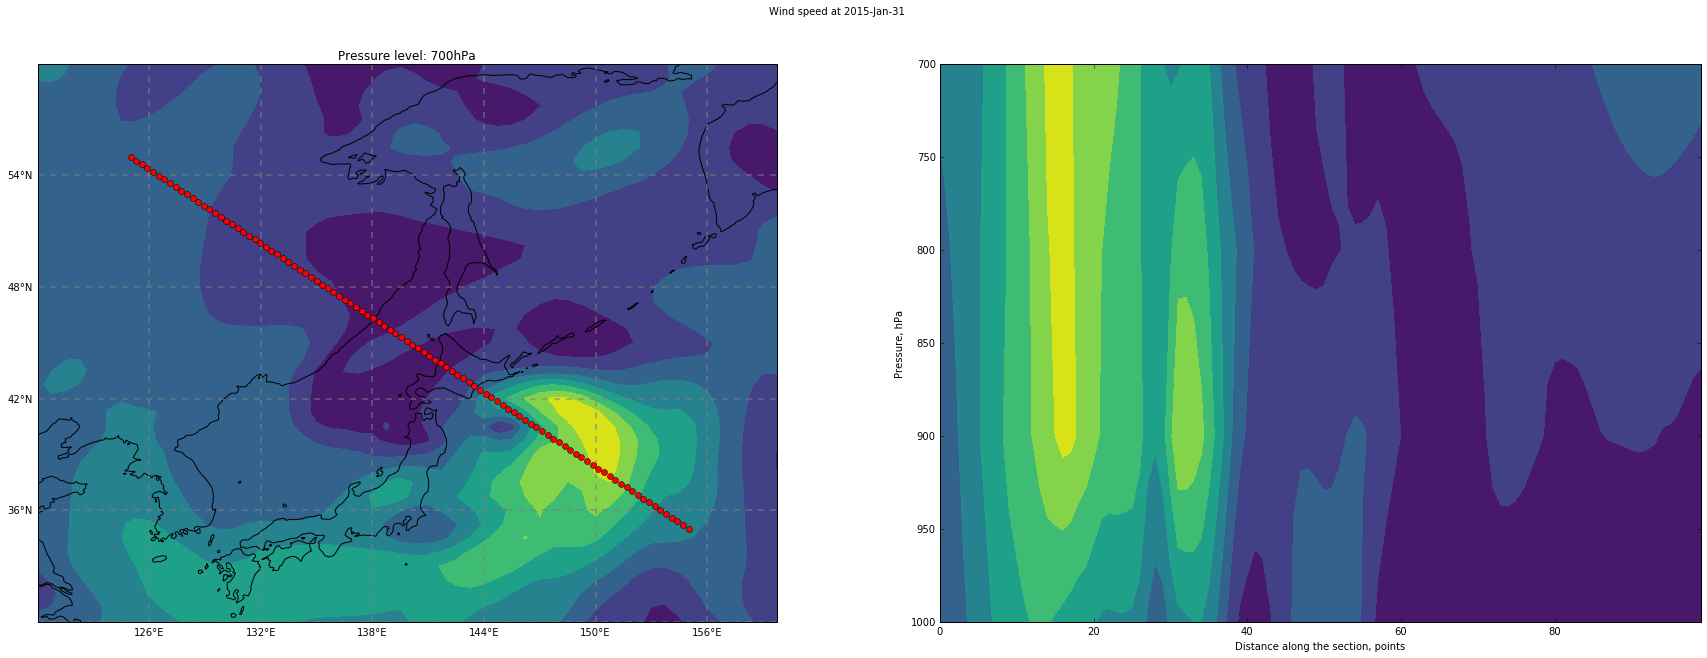

In [23]:
fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.contourf(lon, lat, wspd_subset.data[it,ilev,...], cmap=plt.cm.viridis)
#--------Fancy formatting---------
gl = ax1.gridlines(crs=ccrs.PlateCarree(), # using the same projection
                  draw_labels=True, # add labels
                  linewidth=2, color='gray', alpha=0.5, linestyle='--') # grid line specs
# Remove labels above and on the right of the map (note that Python allows the double equality)
gl.xlabels_top = gl.ylabels_right = False
# Format the labels using the formatters imported from cartopy
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#---------------------------------
ax1.plot(seclon, seclat, color='r', linestyle='', marker='o', linewidth=3)
ax1.set_title('Pressure level: {}hPa'.format(wspd_subset.coord('pressure_level').points[ilev]))


ax2 = fig.add_subplot(122)
ax2.contourf(np.arange(section.data.shape[2]), section.coord('pressure_level').points, section.data[it,...], cmap=plt.cm.viridis)
ax2.invert_yaxis()
ax2.set_ylabel('Pressure, hPa')
ax2.set_xlabel('Distance along the section, points')

fig.suptitle('Wind speed at {}'.format(wspd_subset.coord('time').units.num2date(wspd_subset.coord('time').points[0]).strftime('%Y-%b-%d')))

In [24]:
HTML(html)